# Model Tuning
## Goals
1. Establish baseline performance from previous models.
2. Systematically tune hyperparameters of XGBoost using GridSearchCV.
3. Compare tuned vs. baseline models.
4. Save the best-performing tuned model.

In [1]:
# Imports
from pathlib import Path
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

import joblib
import optuna
from optuna.samplers import TPESampler

/Users/Effy/Documents/Projects/ML_Portfolio/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
CLEANED_FILE_PATH: str = "../../data/cleaned/regression"
MODELS_SAVE_PATH: str = "../../models/regression"
FIGURES_SAVE_PATH: str = "../../figures"

RANDOM_STATE: int = 42

In [3]:
# Load Data
output_dir = Path(CLEANED_FILE_PATH)

X_train = pl.read_csv(output_dir / "X_train_engineered.csv").to_numpy()
X_val = pl.read_csv(output_dir / "X_val_engineered.csv").to_numpy()

y_train_log = pl.read_csv(output_dir / "y_train_log.csv")["annual_salary_log"].to_numpy()
y_val_log = pl.read_csv(output_dir / "y_val_log.csv")["annual_salary_log"].to_numpy()

print(f"Data loaded:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_val shape: {X_val.shape}")
print(f"  y_train shape: {y_train_log.shape}")
print(f"  y_val shape: {y_val_log.shape}")

Data loaded:
  X_train shape: (15786, 54)
  X_val shape: (3383, 54)
  y_train shape: (15786,)
  y_val shape: (3383,)


In [6]:
def inverse_transform_salary(log_salary_pred: np.ndarray) -> np.ndarray:
    """Inverse transformation: log(x+1) → x"""
    return np.expm1(log_salary_pred)

def evaluate_model(model, X: np.ndarray, y_true_log: np.ndarray, model_name: str) -> dict:
    """Evaluate model on both log and original scales"""
    y_pred_log = model.predict(X)
    
    # Log scale metrics
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    r2_log = r2_score(y_true_log, y_pred_log)
    
    # Original scale metrics
    y_true_orig = inverse_transform_salary(y_true_log)
    y_pred_orig = inverse_transform_salary(y_pred_log)
    
    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    r2_orig = r2_score(y_true_orig, y_pred_orig)
    
    print(f"\n--- {model_name} ---")
    print(f"RMSE (log): {rmse_log:.4f}")
    print(f"MAE (log):  {mae_log:.4f}")
    print(f"R² (log):   {r2_log:.4f}")
    print(f"RMSE ($): ${rmse_orig:,.0f}")
    print(f"MAE ($):  ${mae_orig:,.0f}")
    print(f"R² ($):   {r2_orig:.4f}")
    
    return {
        'model_name': model_name,
        'rmse_log': rmse_log,
        'mae_log': mae_log,
        'r2_log': r2_log,
        'rmse_orig': rmse_orig,
        'mae_orig': mae_orig,
        'r2_orig': r2_orig
    }

## Baseline Performance
Let's establish the performance of our initial models before tuning for comparison.

In [7]:
# Load baseline models
ridge_baseline = joblib.load(Path(MODELS_SAVE_PATH) / "ridge_model.pkl")
xgb_baseline = joblib.load(Path(MODELS_SAVE_PATH) / "xgb_model.pkl")

print("✓ Baseline models loaded\n")

# Evaluate baselines
ridge_baseline_results = evaluate_model(ridge_baseline, X_val, y_val_log, "Ridge Baseline")
xgb_baseline_results = evaluate_model(xgb_baseline, X_val, y_val_log, "XGBoost Baseline")

✓ Baseline models loaded


--- Ridge Baseline ---
RMSE (log): 0.4106
MAE (log):  0.3168
R² (log):   0.4076
RMSE ($): $50,855
MAE ($):  $31,345
R² ($):   0.3030

--- XGBoost Baseline ---
RMSE (log): 0.3949
MAE (log):  0.3047
R² (log):   0.4521
RMSE ($): $49,300
MAE ($):  $30,346
R² ($):   0.3449


/Users/Effy/Documents/Projects/ML_Portfolio/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(


## XGBoost Hyperparameter Tuning
We use a **two-stage approach**:
1. **RandomizedSearchCV**: Broad exploration of parameter space
2. **GridSearchCV**: Fine-grained tuning around best parameters

This balances computational cost with exploration depth.

In [8]:
# Stage 1: Randomized Search for broad exploration
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.15],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 2, 3, 5],
}

xgb_random_search = RandomizedSearchCV(
    XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE, tree_method='hist'),
    param_dist,
    n_iter=30,  # 30 random combinations
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

In [9]:
print(f"Searching {30} random parameter combinations with 5-fold CV...")
xgb_random_search.fit(X_train, y_train_log)

print(f"\nRandomizedSearchCV completed")
print(f"  Best CV Score (RMSE): {np.sqrt(-xgb_random_search.best_score_):.4f}")
print(f"  Best Parameters: {xgb_random_search.best_params_}")

Searching 30 random parameter combinations with 5-fold CV...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

RandomizedSearchCV completed
  Best CV Score (RMSE): 0.3874
  Best Parameters: {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}


In [18]:
# Stage 2: Grid Search for fine-tuning around best parameters

# Get best params from random search
best_params = xgb_random_search.best_params_

# Define narrow grid around best parameters
param_grid = {
    'n_estimators': [best_params['n_estimators'] - 50, 
                     best_params['n_estimators'], 
                     best_params['n_estimators'] + 50],
    'max_depth': [best_params['max_depth'] - 1, 
                  best_params['max_depth'], 
                  best_params['max_depth'] + 1],
    'learning_rate': [best_params['learning_rate'] * 0.8, 
                      best_params['learning_rate'], 
                      best_params['learning_rate'] * 1.2],
    'subsample': [best_params['subsample']],  # Keep best
    'colsample_bytree': [best_params['colsample_bytree']]  # Keep best
}

xgb_grid_search = GridSearchCV(
    XGBRegressor(
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        tree_method='hist',
        # Fix parameters not being tuned
        gamma=best_params.get('gamma', 0),
        min_child_weight=best_params.get('min_child_weight', 1)
    ),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)


In [19]:
print(f"Testing {np.prod([len(v) for v in param_grid.values()])} combinations...")
xgb_grid_search.fit(X_train, y_train_log)

print(f"\nGridSearchCV completed")
print(f"  Best CV Score (RMSE): {np.sqrt(-xgb_grid_search.best_score_):.4f}")
print(f"  Best Parameters: {xgb_grid_search.best_params_}")

# Evaluate on validation set
xgb_grid_results = evaluate_model(
    xgb_grid_search.best_estimator_, 
    X_val, 
    y_val_log, 
    "XGBoost Grid-Tuned"
)

Testing 27 combinations...
Fitting 5 folds for each of 27 candidates, totalling 135 fits

GridSearchCV completed
  Best CV Score (RMSE): 0.3872
  Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.04000000000000001, 'max_depth': 4, 'n_estimators': 550, 'subsample': 0.8}

--- XGBoost Grid-Tuned ---
RMSE (log): 0.3945
MAE (log):  0.3051
R² (log):   0.4532
RMSE ($): $49,172
MAE ($):  $30,312
R² ($):   0.3483


In [20]:
# 3. Train Final Tuned Models
xgb_tuned = XGBRegressor(
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    tree_method='hist',
    **xgb_grid_search.best_params_
)

xgb_tuned.fit(X_train, y_train_log)

print("Final tuned XGBoost model trained.")
# Save tuned model
joblib.dump(xgb_tuned, Path(MODELS_SAVE_PATH) / "xgb_tuned.pkl")
print(f"Saved to: {Path(MODELS_SAVE_PATH) / 'xgb_tuned.pkl'}")

Final tuned XGBoost model trained.
Saved to: ../../models/regression/xgb_tuned.pkl


## Comparison

In [21]:
# Evaluate tuned model
xgb_tuned_results = evaluate_model(xgb_tuned, X_val, y_val_log, "XGBoost Tuned")

# Calculate improvements
rmse_improvement = xgb_baseline_results['rmse_orig'] - xgb_tuned_results['rmse_orig']
rmse_improvement_pct = (rmse_improvement / xgb_baseline_results['rmse_orig']) * 100

mae_improvement = xgb_baseline_results['mae_orig'] - xgb_tuned_results['mae_orig']
mae_improvement_pct = (mae_improvement / xgb_baseline_results['mae_orig']) * 100

r2_improvement = xgb_tuned_results['r2_orig'] - xgb_baseline_results['r2_orig']
r2_improvement_pct = (r2_improvement / xgb_baseline_results['r2_orig']) * 100 if xgb_baseline_results['r2_orig'] != 0 else 0

print(f"\n📊 Improvement Analysis:")
print(f"  RMSE: ${rmse_improvement:,.0f} ({rmse_improvement_pct:+.1f}%)")
print(f"  MAE:  ${mae_improvement:,.0f} ({mae_improvement_pct:+.1f}%)")
print(f"  R²:   {r2_improvement:+.4f} ({r2_improvement_pct:+.1f}%)")


--- XGBoost Tuned ---
RMSE (log): 0.3944
MAE (log):  0.3046
R² (log):   0.4534
RMSE ($): $49,148
MAE ($):  $30,264
R² ($):   0.3490

📊 Improvement Analysis:
  RMSE: $152 (+0.3%)
  MAE:  $83 (+0.3%)
  R²:   +0.0040 (+1.2%)


## Visualization

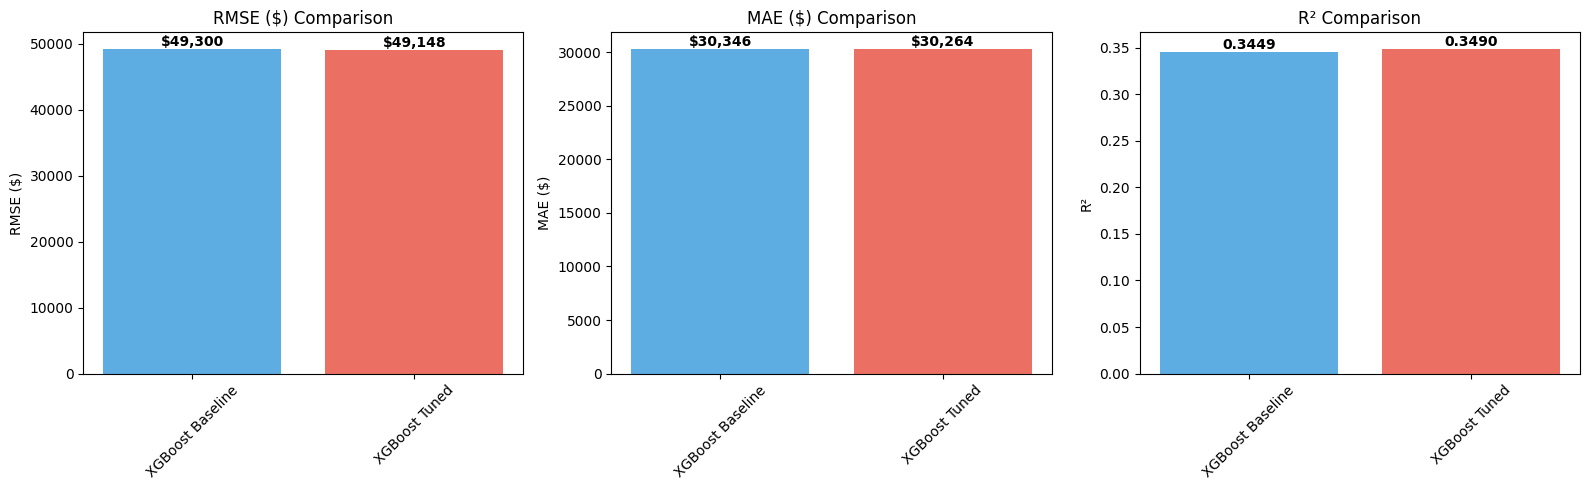

In [22]:
comparison_df = pl.DataFrame({
    'Model': ['XGBoost Baseline', 'XGBoost Tuned'],
    'RMSE ($)': [xgb_baseline_results['rmse_orig'], xgb_tuned_results['rmse_orig']],
    'MAE ($)': [xgb_baseline_results['mae_orig'], xgb_tuned_results['mae_orig']],
    'R²': [xgb_baseline_results['r2_orig'], xgb_tuned_results['r2_orig']],
})

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = [('RMSE ($)', 0), ('MAE ($)', 1), ('R²', 2)]
colors = ['#3498db', '#e74c3c']

for (metric_name, idx), ax in zip(metrics, axes):
    values = comparison_df[metric_name].to_list()
    bars = ax.bar(comparison_df['Model'], values, color=colors, alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'${val:,.0f}' if metric_name != 'R²' else f'{val:.4f}',
                ha='center', va='bottom', fontweight='bold')
    
    ax.set_title(f'{metric_name} Comparison')
    ax.set_ylabel(metric_name)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(Path(FIGURES_SAVE_PATH) / "tuning_comparison.png", dpi=300)
plt.show()

## Summary
Tuning Methods Used:
  1. **RandomizedSearchCV**: 30 random combinations
  2. **GridSearchCV**: Fine-tuning around best random parameters

In [23]:
print(f"""
Results:
  - RMSE Improvement: ${rmse_improvement:,.0f} ({rmse_improvement_pct:+.1f}%)
  - Best Model: {'XGBoost Tuned' if rmse_improvement > 0 else 'Baseline'}
  
Tuned Hyperparameters:
  {xgb_grid_search.best_params_}

Models Saved:
  ✓ xgb_tuned.pkl (tuned model)
""")


Results:
  - RMSE Improvement: $152 (+0.3%)
  - Best Model: XGBoost Tuned

Tuned Hyperparameters:
  {'colsample_bytree': 0.9, 'learning_rate': 0.04000000000000001, 'max_depth': 4, 'n_estimators': 550, 'subsample': 0.8}

Models Saved:
  ✓ xgb_tuned.pkl (tuned model)



**Improvement Achieved**: $152 RMSE reduction (0.3%)

Let's also check if this is real or just noise.